# Template - Strategy - Backtesting 

### Import Library

In [149]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [150]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [151]:
data = dataset.copy()

In [152]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [153]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [154]:
def prepare_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['Close_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['first_close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    day_data = day_data.dropna()

    data = htd.assign(time_d=pd.PeriodIndex(htd.index, freq='1D').to_timestamp())
    data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
    data.dropna(inplace=True)

    data["current"] = data.index + pd.DateOffset(minutes=5)
    data['mom_y'] = 100 * (data.Close - data.prev_day_Close) / data.prev_day_Close
    data['body_rate'] = (data.Close - data.first_close) / (data.prev_high - data.prev_low)
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 42)
    data = data.assign(ADX=adx['ADX_42'])
    data['signal'] = data.apply(lambda r: cal_signal(r), axis=1)
    data['signal_shift'] = data['signal'].shift(1)
    data.dropna(inplace=True)
    data['ADX'] = round(data['ADX'])
    return data[['Open', 'Close', 'High', 'Low', 'Volume', 'signal', 'ADX', 'current']]


def cal_signal(row):
    signal = ''
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65 and row['ADX'] < 26.5:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39 and row['ADX'] < 26.5:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

In [155]:
class Momentum(Strategy):
    max_risk = 5.5
    tp_step = 20
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return

        if current_time.hour == 13 and current_time.minute == 55:
            close_price = self.data.Close[-1]
            signal = self.data.signal[-1]
            if signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_risk
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_risk
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)

In [156]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [157]:
prepared_data

,Open,Close,High,Low,Volume,signal,ADX,current
Date,,,,,,,,
2020-11-04 13:05:00,912.6,912.8,913.3,912.1,2847,,13.0,2020-11-04 13:10:00
2020-11-04 13:10:00,912.6,912.9,913.4,912.3,1396,,13.0,2020-11-04 13:15:00
2020-11-04 13:15:00,912.9,912.6,913.1,912.1,1892,,13.0,2020-11-04 13:20:00
2020-11-04 13:20:00,912.6,912.8,913.2,912.2,2107,,13.0,2020-11-04 13:25:00
2020-11-04 13:25:00,912.8,914.2,914.4,912.7,3460,long,14.0,2020-11-04 13:30:00
...,...,...,...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.2,1344.4,1342.4,5075,long,17.0,2025-02-07 14:20:00
2025-02-07 14:20:00,1344.2,1344.0,1344.7,1343.6,4865,long,17.0,2025-02-07 14:25:00
2025-02-07 14:25:00,1344.1,1343.3,1344.2,1342.8,5013,,17.0,2025-02-07 14:30:00


In [158]:
bt = Backtest(prepared_data, Momentum, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-04 13:05:00
End                       2025-02-07 14:45:00
Duration                   1556 days 01:40:00
Exposure Time [%]                    2.904649
Equity Final [$]                   1881.65003
Equity Peak [$]                    1891.47264
Return [%]                          25.443335
Buy & Hold Return [%]               47.162577
Return (Ann.) [%]                    5.644287
Volatility (Ann.) [%]                3.104195
Sharpe Ratio                         1.818277
Sortino Ratio                         4.10026
Calmar Ratio                         2.755895
Max. Drawdown [%]                   -2.048077
Avg. Drawdown [%]                   -0.340452
Max. Drawdown Duration      167 days 00:10:00
Avg. Drawdown Duration       13 days 22:07:00
# Trades                                  252
Win Rate [%]                        58.730159
Best Trade [%]                       1.749788
Worst Trade [%]                     -0.662575
Avg. Trade [%]                    

In [159]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,11,15,916.87498,910.8,-6.07498,-0.006626,2020-11-04 14:00:00,2020-11-04 14:20:00,None,0 days 00:20:00
1,-1,113,119,907.02781,910.5,-3.47219,-0.003828,2020-11-06 14:00:00,2020-11-06 14:30:00,None,0 days 00:30:00
2,-1,266,271,915.32532,921.1,-5.77468,-0.006309,2020-11-11 14:00:00,2020-11-11 14:25:00,None,0 days 00:25:00
3,1,366,372,933.17987,935.8,2.62013,0.002808,2020-11-13 14:00:00,2020-11-13 14:30:00,None,0 days 00:30:00
4,-1,417,423,933.11998,917.5,15.61998,0.016740,2020-11-16 14:00:00,2020-11-16 14:30:00,None,0 days 00:30:00
...,...,...,...,...,...,...,...,...,...,...,...
247,-1,53124,53130,1312.60610,1311.9,0.70610,0.000538,2025-01-09 14:00:00,2025-01-09 14:30:00,None,0 days 00:30:00
248,-1,53175,53181,1309.00718,1295.6,13.40718,0.010242,2025-01-10 14:00:00,2025-01-10 14:30:00,None,0 days 00:30:00
249,1,53430,53436,1315.69459,1318.9,3.20541,0.002436,2025-01-17 14:00:00,2025-01-17 14:30:00,None,0 days 00:30:00
250,-1,53532,53538,1318.70427,1321.3,-2.59573,-0.001968,2025-01-21 14:00:00,2025-01-21 14:30:00,None,0 days 00:30:00


In [160]:
trades = stats['_trades']

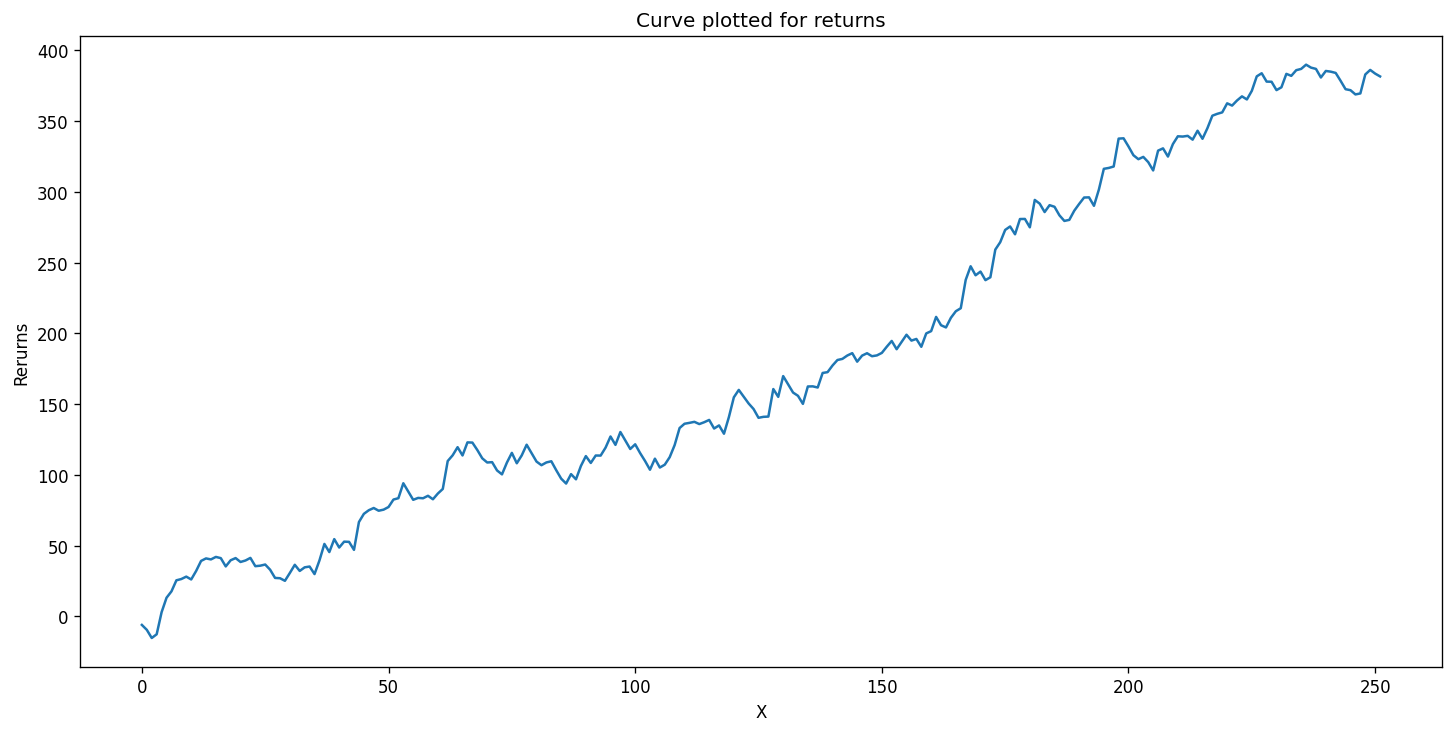

In [169]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

## Trades Analytics

<Axes: xlabel='day_of_week'>

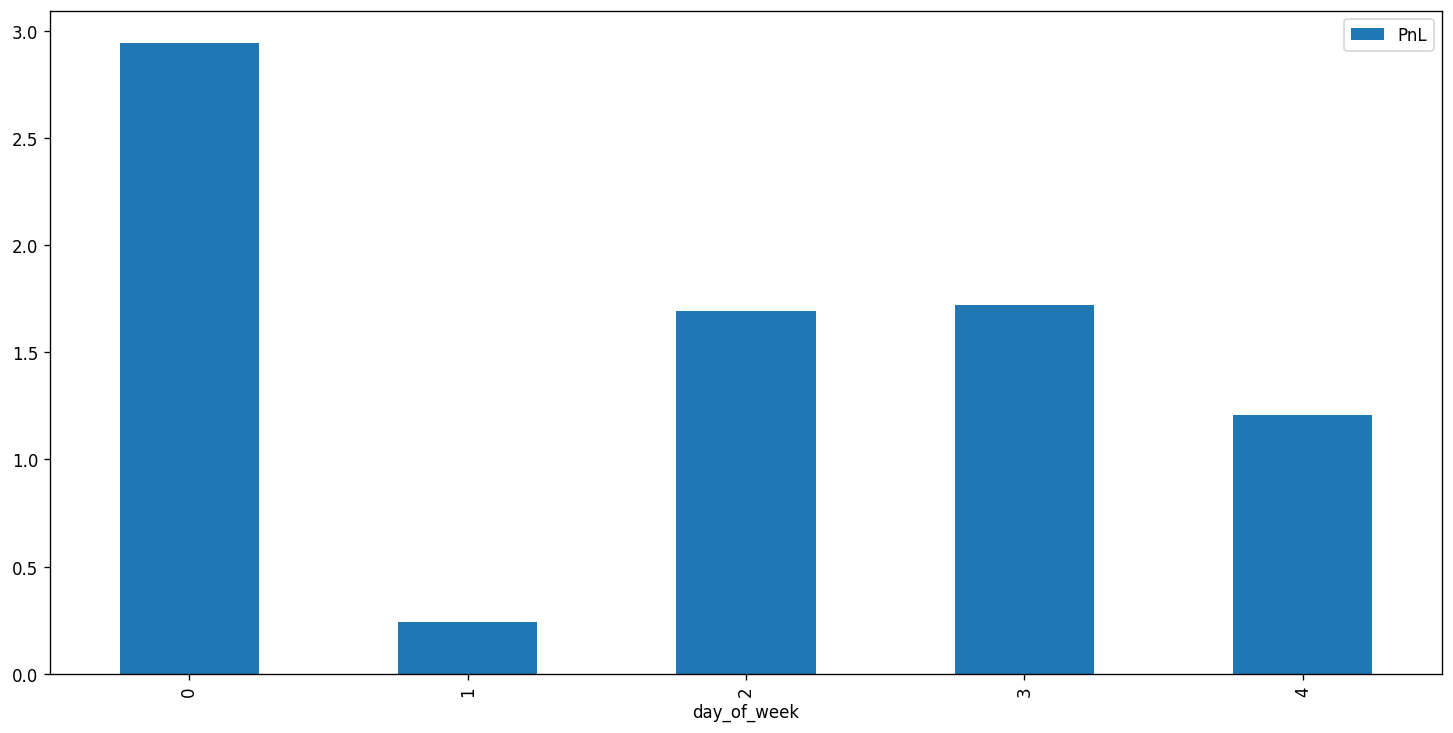

In [161]:
trades['day_of_week'] = trades['EntryTime'].dt.dayofweek
trades_grouped_by_dow = trades.groupby(['day_of_week'])[['PnL']].mean()
trades_grouped_by_dow.plot.bar()

<Axes: xlabel='day_of_month'>

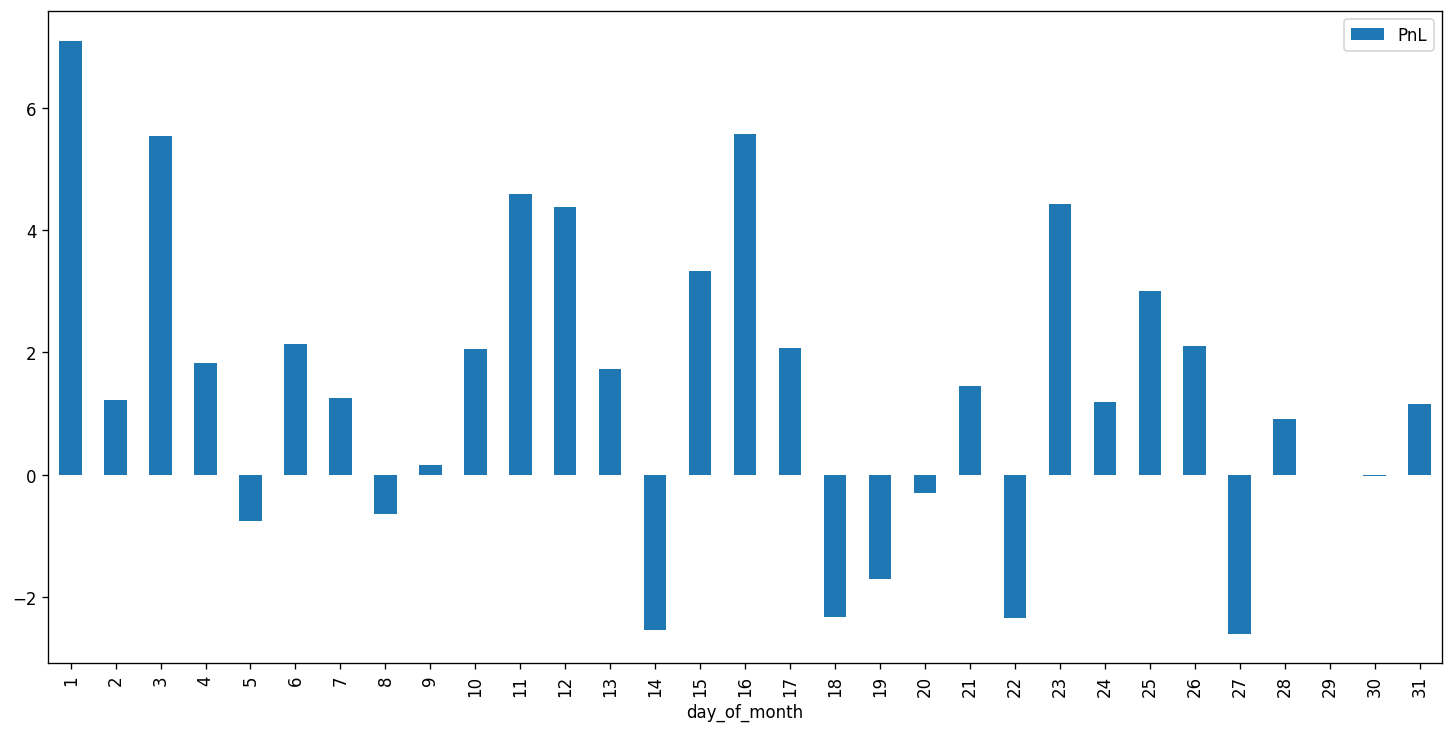

In [162]:
trades['day_of_month'] = trades['EntryTime'].dt.day
trades_grouped_by_dom = trades.groupby(['day_of_month'])[['PnL']].mean()
trades_grouped_by_dom.plot.bar()

<Axes: xlabel='day_of_month'>

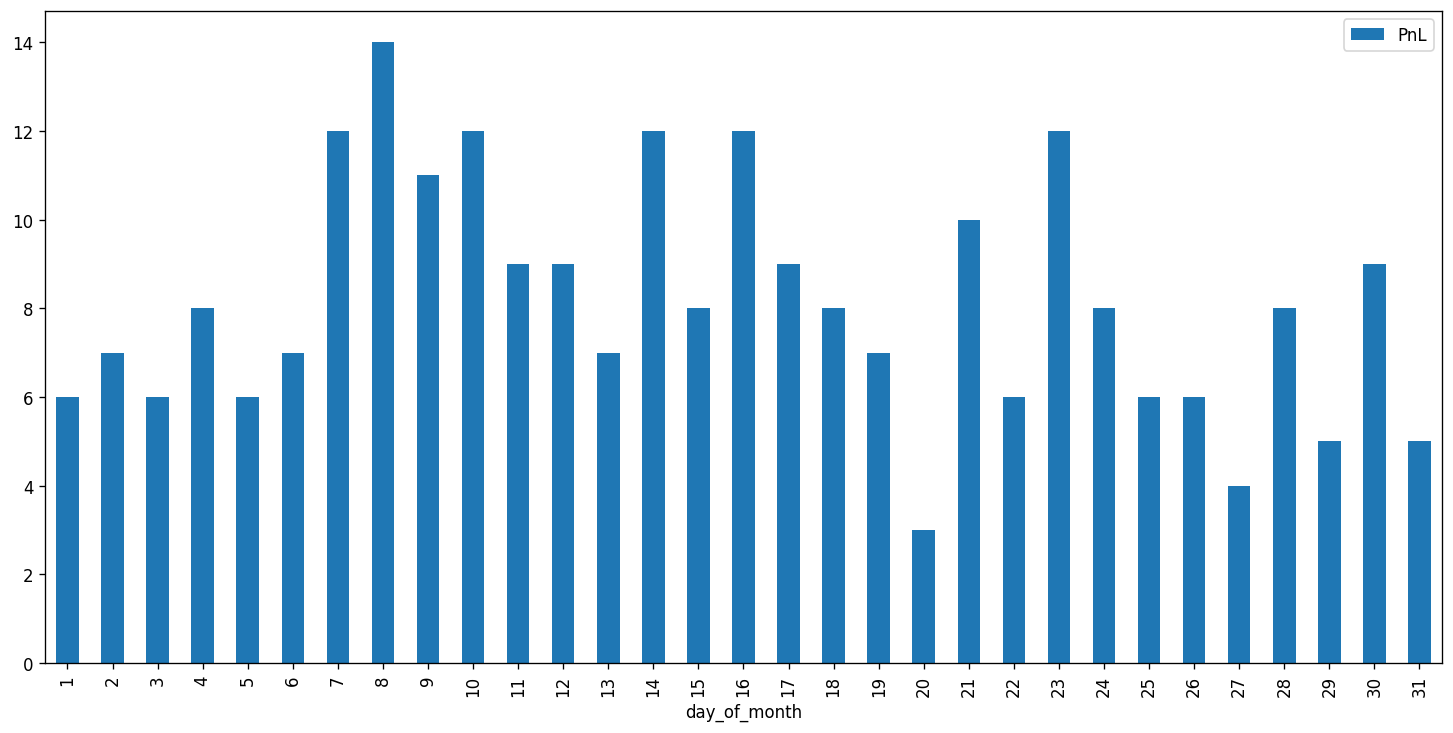

In [163]:
trades_grouped_by_domc = trades.groupby(['day_of_month'])[['PnL']].count()
trades_grouped_by_domc.plot.bar()

<Axes: xlabel='month'>

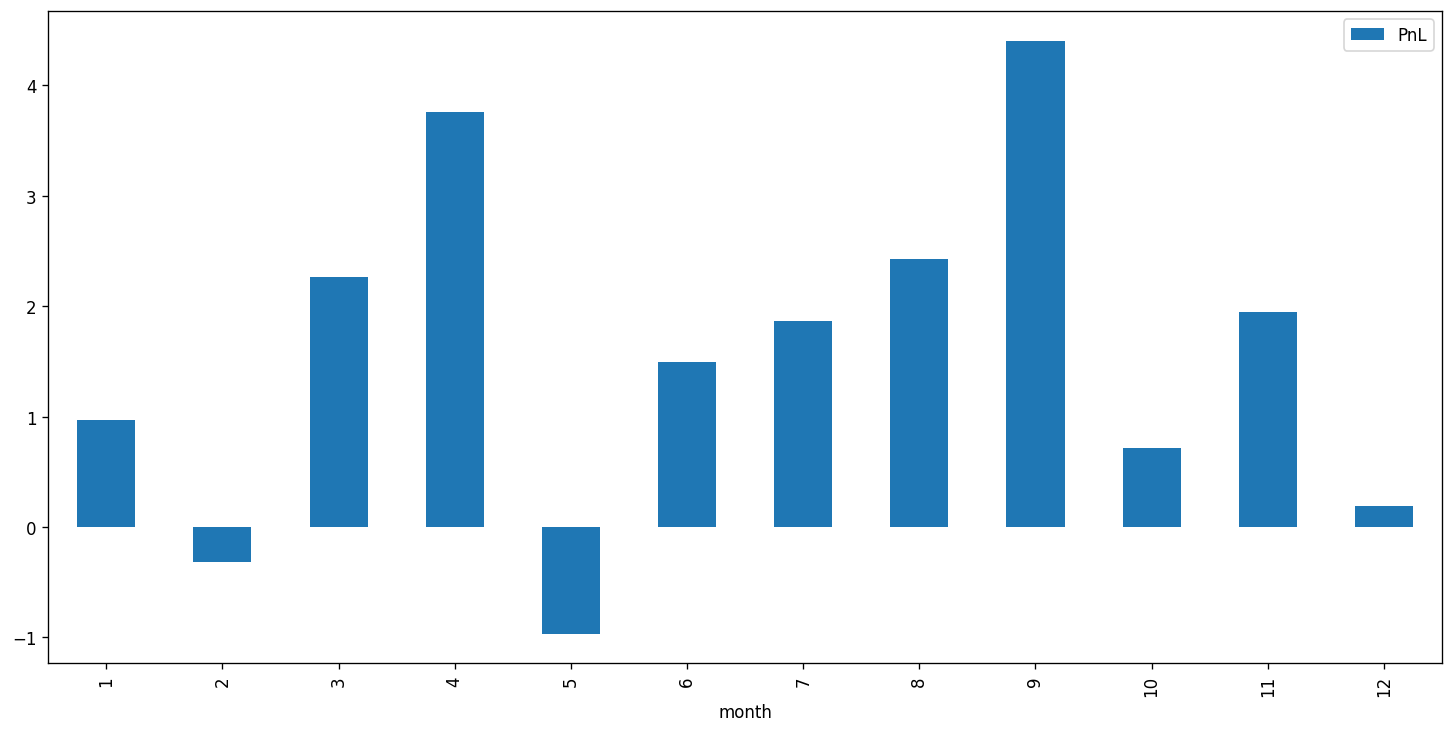

In [164]:
trades['month'] = trades['EntryTime'].dt.month
trades_grouped_by_month = trades.groupby(['month'])[['PnL']].mean()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='month'>

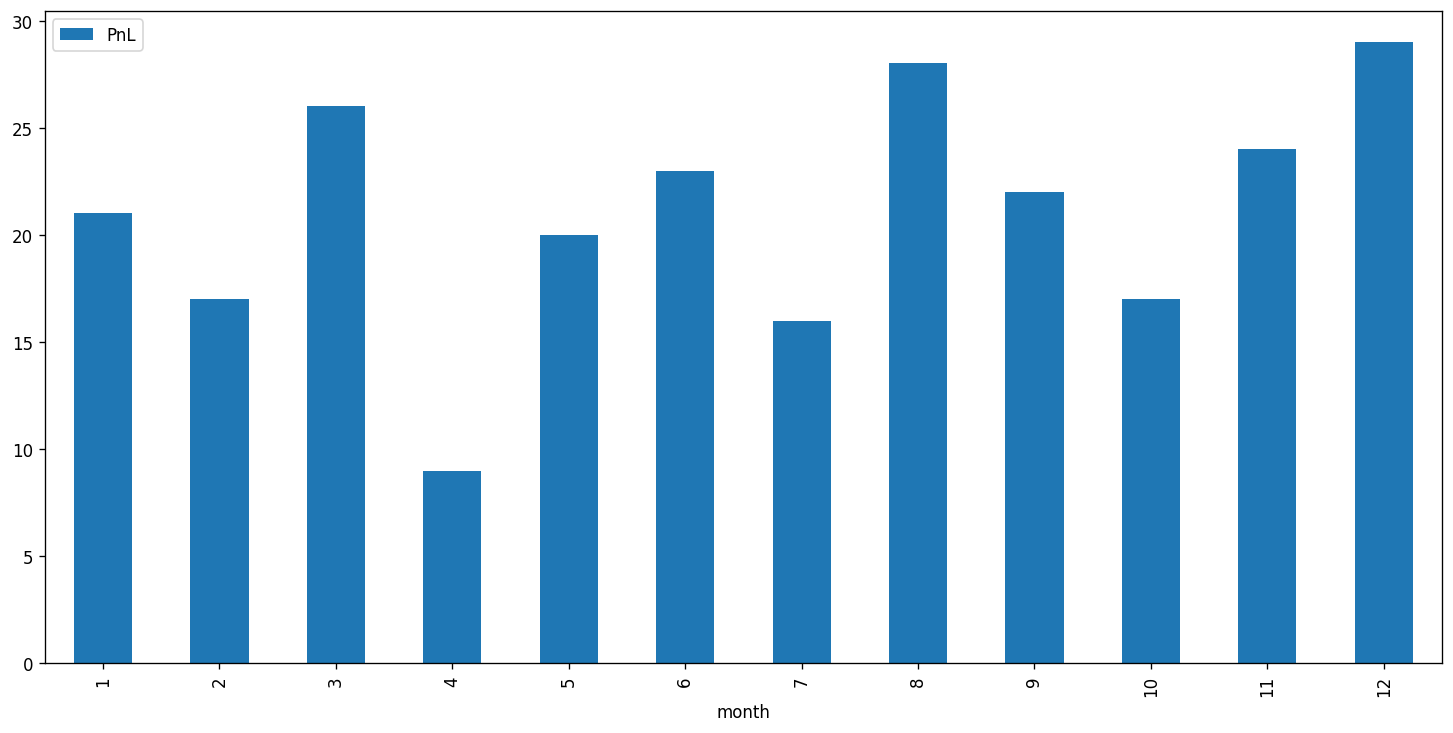

In [165]:
trades_grouped_by_month = trades.groupby(['month'])[['PnL']].count()
trades_grouped_by_month.plot.bar()

<Axes: xlabel='year'>

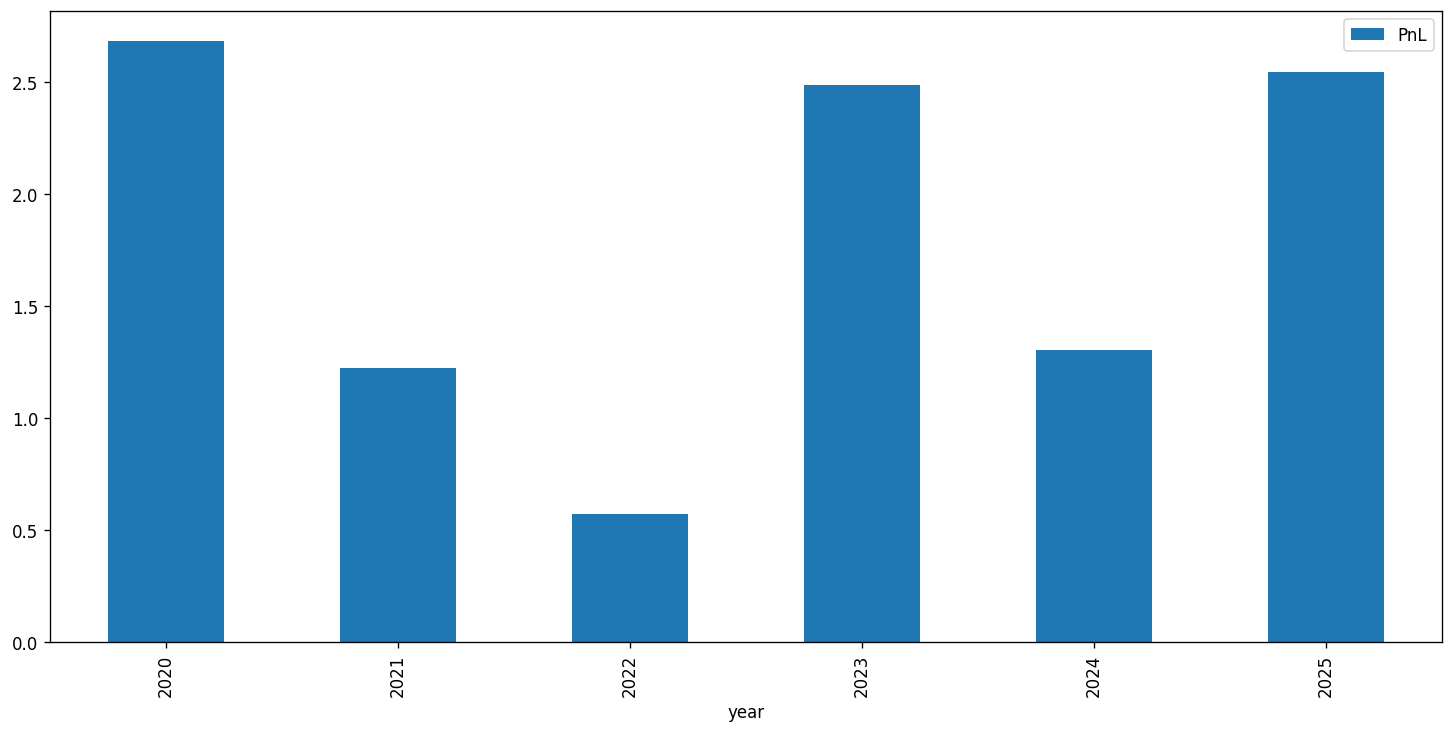

In [166]:
trades['year'] = trades['EntryTime'].dt.year
trades_grouped_by_year = trades.groupby(['year'])[['PnL']].mean()
trades_grouped_by_year.plot.bar()

In [167]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades.tail(30)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,month,year,Open,Close,High,Low,Volume,signal,ADX,current
222,-1,48640,48646,1310.60670,1307.0,3.60670,0.002752,2024-09-05 14:00:00,2024-09-05 14:30:00,None,...,9,2024,1313.4,1310.9,1313.5,1310.9,8015,short,14.0,2024-09-05 14:00:00
223,-1,48793,48799,1296.11105,1293.2,2.91105,0.002246,2024-09-10 14:00:00,2024-09-10 14:30:00,None,...,9,2024,1297.4,1296.5,1297.5,1293.7,9600,short,17.0,2024-09-10 14:00:00
224,-1,48946,48952,1293.61180,1295.8,-2.18820,-0.001692,2024-09-13 14:00:00,2024-09-13 14:30:00,None,...,9,2024,1294.1,1294.2,1294.5,1293.2,4012,short,11.0,2024-09-13 14:00:00
225,-1,48997,49003,1290.11285,1284.0,6.11285,0.004738,2024-09-16 14:00:00,2024-09-16 14:30:00,None,...,9,2024,1291.1,1290.7,1291.5,1290.4,4636,short,15.0,2024-09-16 14:00:00
226,1,49048,49054,1290.08691,1300.3,10.21309,0.007917,2024-09-17 14:00:00,2024-09-17 14:30:00,None,...,9,2024,1288.2,1289.9,1290.0,1288.0,8921,long,17.0,2024-09-17 14:00:00
227,-1,49760,49766,1337.19872,1335.0,2.19872,0.001644,2024-10-07 14:00:00,2024-10-07 14:30:00,None,...,10,2024,1341.3,1337.3,1341.3,1337.2,7534,short,23.0,2024-10-07 14:00:00
228,1,49811,49814,1349.20464,1343.3,-5.90464,-0.004376,2024-10-08 14:00:00,2024-10-08 14:15:00,None,...,10,2024,1346.5,1348.8,1348.8,1346.2,8900,long,18.0,2024-10-08 14:00:00
229,1,49862,49868,1354.90635,1354.8,-0.10635,-0.000078,2024-10-09 14:00:00,2024-10-09 14:30:00,None,...,10,2024,1354.1,1354.3,1355.0,1353.5,3953,long,15.0,2024-10-09 14:00:00
230,-1,49964,49969,1358.99218,1364.9,-5.90782,-0.004347,2024-10-11 14:00:00,2024-10-11 14:25:00,None,...,10,2024,1360.2,1359.4,1360.2,1358.5,4824,short,16.0,2024-10-11 14:00:00
231,-1,50015,50021,1362.89101,1360.9,1.99101,0.001461,2024-10-14 14:00:00,2024-10-14 14:30:00,None,...,10,2024,1363.3,1363.2,1364.0,1362.2,3287,short,12.0,2024-10-14 14:00:00


<Axes: xlabel='ADX'>

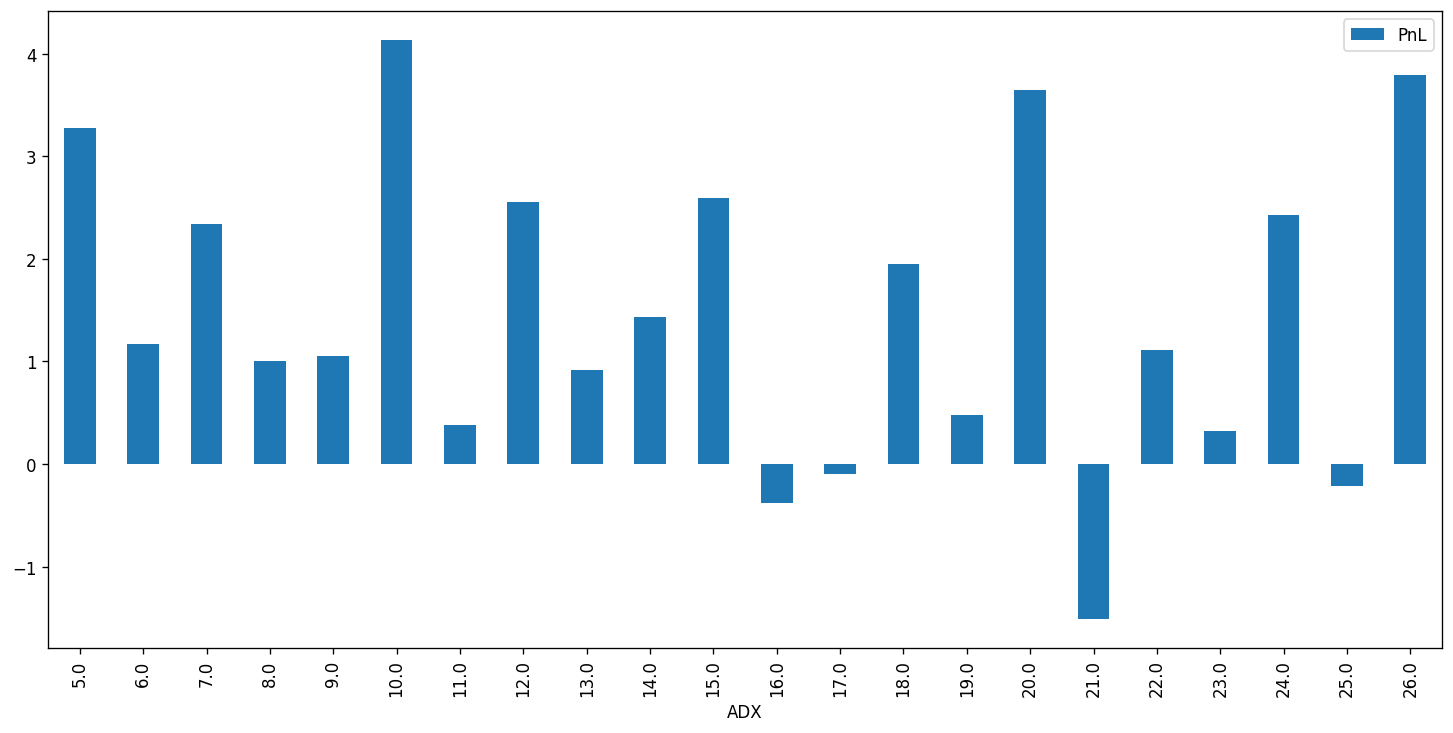

In [168]:
trades_grouped_by_adx = join_trades.groupby(['ADX'])[['PnL']].mean()
trades_grouped_by_adx.plot.bar()

In [63]:
long_trades = trades[trades.Size==1]
short_trades = trades[trades.Size==-1]

## Optimize Params 

In [145]:
max_risk_params = [x / 10.0 for x in range(20, 60, 5)]
tp_params = [x / 10 for x in range(5, 200, 5)]
optimize_stats, heatmap = bt.optimize(max_risk=max_risk_params,
                                      tp_step = tp_params,
                    maximize='Return [%]',
                    random_state=0,
                    return_heatmap=True)

In [146]:
optimize_stats

Start                     2020-11-04 13:05:00
End                       2025-02-07 14:45:00
Duration                   1556 days 01:40:00
Exposure Time [%]                    2.912063
Equity Final [$]                   1881.84148
Equity Peak [$]                    1891.66409
Return [%]                          25.456099
Buy & Hold Return [%]               47.162577
Return (Ann.) [%]                    5.646845
Volatility (Ann.) [%]                 3.12797
Sharpe Ratio                         1.805275
Sortino Ratio                        4.079699
Calmar Ratio                         2.771728
Max. Drawdown [%]                   -2.037301
Avg. Drawdown [%]                    -0.34766
Max. Drawdown Duration      167 days 00:10:00
Avg. Drawdown Duration       14 days 05:00:00
# Trades                                  253
Win Rate [%]                        58.498024
Best Trade [%]                       1.704615
Worst Trade [%]                     -0.662575
Avg. Trade [%]                    

In [147]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.figsize'] = [18, 6]

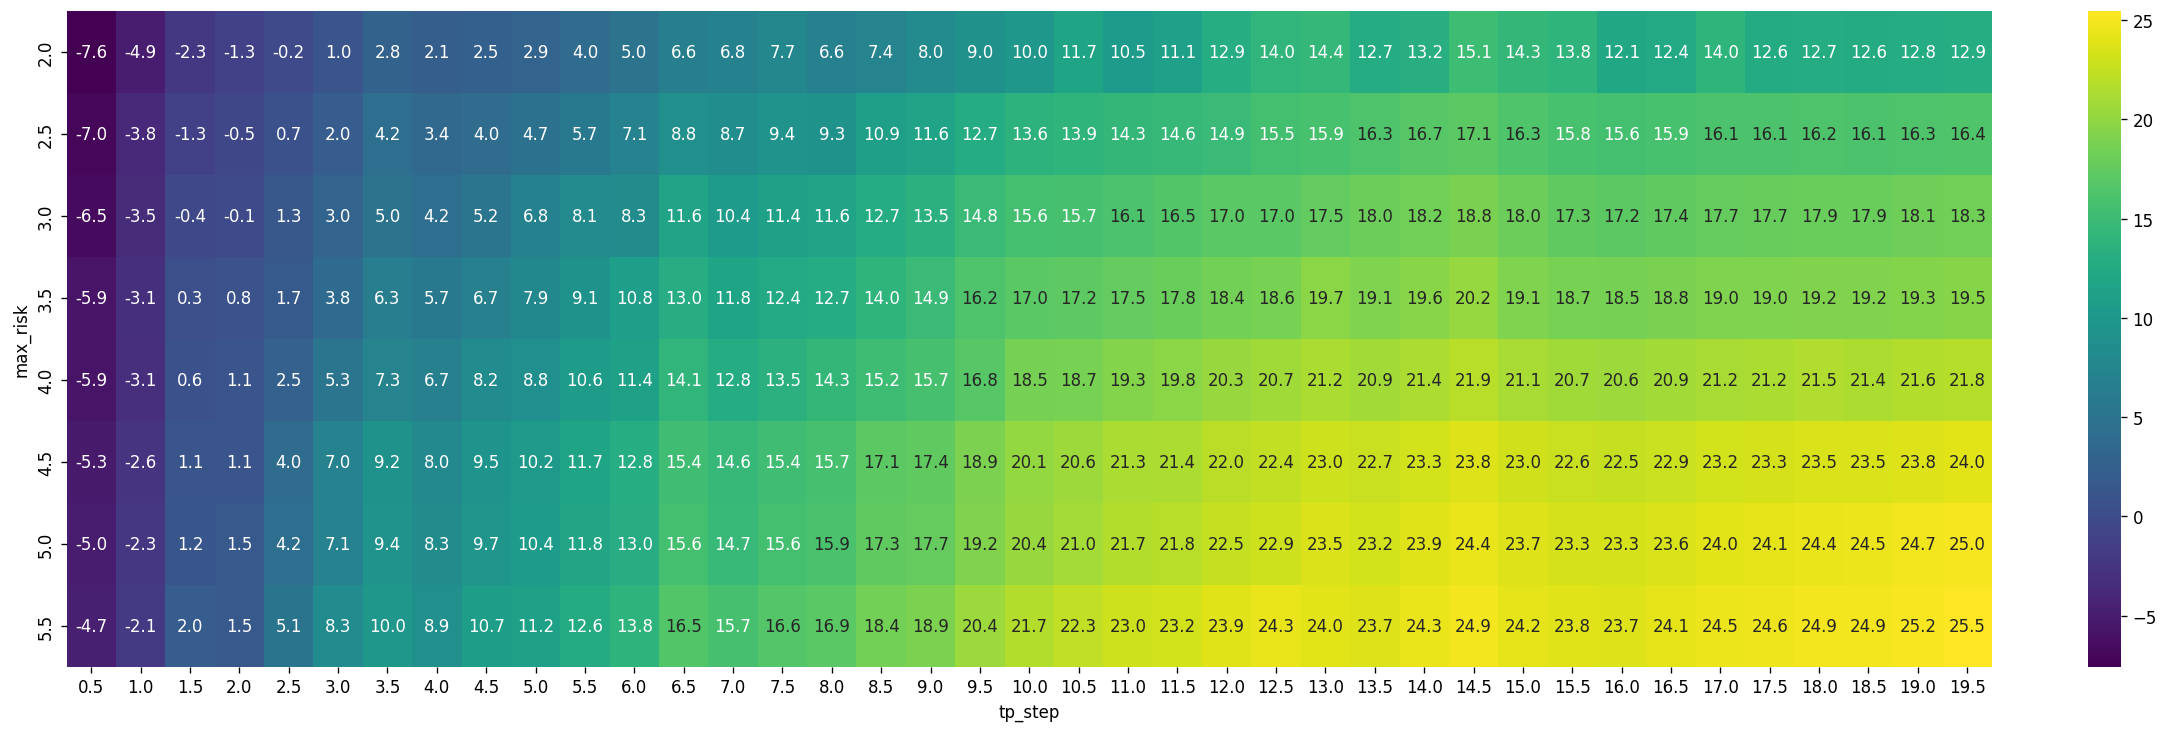

In [148]:
import seaborn as sns
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.1f')
plt.show()